<a href="https://colab.research.google.com/github/SiyandaCaddy/firstproject.com/blob/main/Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Problem 2: Fraud Detection in Banking (Clustering + Classification)
# ------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, classification_report,
                             f1_score, precision_recall_curve, precision_recall_fscore_support)

# -------------------------
# 1) Load dataset
# -------------------------
from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    file_path = fname

df = pd.read_csv(file_path)
print("Data shape:", df.shape)
print(df.head())

# Rename label column if needed
if 'Is_Fraud (Labeled Subset)' in df.columns:
    df = df.rename(columns={'Is_Fraud (Labeled Subset)': 'Is_Fraud'})
df['Is_Fraud'] = df['Is_Fraud'].astype(int)

Saving Question 2 Datasets .csv to Question 2 Datasets  (1).csv
Data shape: (200, 6)
   Index   Amount  Time_Hour Location Merchant  Is_Fraud (Labeled Subset)
0      0   816.44          7      ATM   Retail                        0.0
1      1   999.96          1      ATM  Grocery                        0.0
2      2  1443.20          7   Online     Food                        0.0
3      3   222.09         12      ATM     Food                        0.0
4      4   288.64         12   Online  Grocery                        0.0


In [14]:
# -------------------------
# 2) Feature Engineering
# -------------------------

# Basic engineered features
df['log_amount'] = np.log1p(df['Amount'])
df['is_night'] = df['Time_Hour'].apply(lambda h: 1 if (h >= 22 or h <= 5) else 0)

# Merchant-based deviation
merchant_mean = df.groupby('Merchant')['Amount'].transform('mean')
df['amt_minus_merchant_mean'] = df['Amount'] - merchant_mean
df['amt_ratio_to_merchant_mean'] = df['Amount'] / (merchant_mean + 1e-9)

# Additional features
df['high_amount_flag'] = df['Amount'].apply(lambda x: 1 if x > df['Amount'].quantile(0.95) else 0)
df['hour_bucket'] = pd.cut(df['Time_Hour'], bins=[0,6,12,18,24], labels=[0,1,2,3])

# Target encoding for categorical features
df['merchant_fraud_rate'] = df.groupby('Merchant')['Is_Fraud'].transform('mean')
df['location_fraud_rate'] = df.groupby('Location')['Is_Fraud'].transform('mean')

In [15]:
# -------------------------
# 3) K-Means clustering
# -------------------------
numeric_features = ['Amount', 'Time_Hour', 'log_amount', 'amt_minus_merchant_mean',
                    'amt_ratio_to_merchant_mean', 'is_night', 'high_amount_flag',
                    'merchant_fraud_rate', 'location_fraud_rate']

categorical_features = ['Location', 'Merchant']

preproc_for_clust = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_for_clust = preproc_for_clust.fit_transform(df[numeric_features + categorical_features])

# Fit KMeans
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['cluster_km'] = kmeans.fit_predict(X_for_clust)

# Add cluster distance as a feature
from sklearn.metrics import pairwise_distances
cluster_centers = kmeans.cluster_centers_
distances = pairwise_distances(X_for_clust, cluster_centers[df['cluster_km']])
df['cluster_distance'] = distances.diagonal()


In [16]:
# -------------------------
# 4) Supervised Classification
# -------------------------
feature_cols = numeric_features + categorical_features + ['cluster_km', 'cluster_distance']
X = df[feature_cols]
y = df['Is_Fraud']

preproc_supervised = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features + ['cluster_distance']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cluster', 'passthrough', ['cluster_km'])
])

rf_pipeline = Pipeline([
    ('pre', preproc_supervised),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))
])

nb_pipeline = Pipeline([
    ('pre', preproc_supervised),
    ('clf', GaussianNB())
])


In [17]:
# -------------------------
# 5) Train/Test split & SMOTE
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preproc = preproc_supervised.fit(X_train)
X_train_trans = preproc.transform(X_train)
X_test_trans = preproc.transform(X_test)

if IMBLEARN_AVAILABLE:
    from collections import Counter
    minority_count = y_train.value_counts().min()
    if minority_count < 2:
        X_train_res, y_train_res = X_train_trans, y_train
    else:
        k_neighbors = max(1, minority_count - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train_trans, y_train)

    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train_res, y_train_res)
    y_pred = rf.predict(X_test_trans)
else:
    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)

print("\nRandom Forest - Holdout classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Random Forest - Holdout classification report:
              precision    recall  f1-score   support

          -1     0.4737    0.4500    0.4615        20
           0     0.4762    0.5263    0.5000        19
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.4750        40
   macro avg     0.3166    0.3254    0.3205        40
weighted avg     0.4630    0.4750    0.4683        40

Confusion Matrix:
 [[ 9 11  0]
 [ 9 10  0]
 [ 1  0  0]]



Best threshold by F1: 0.325, F1=0.065

Confusion matrix at best threshold:
[[10 29]
 [ 0  1]]

Classification report at best threshold:
              precision    recall  f1-score   support

           0     1.0000    0.2564    0.4082        39
           1     0.0333    1.0000    0.0645         1

    accuracy                         0.2750        40
   macro avg     0.5167    0.6282    0.2363        40
weighted avg     0.9758    0.2750    0.3996        40



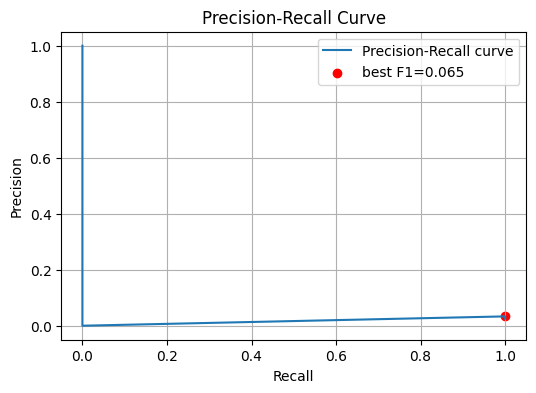

In [19]:
# -------------------------
# 6) Threshold Tuning (PR Curve)
# -------------------------
# Map labels to binary (1=fraud, others=0)
y_test_bin = y_test.apply(lambda x: 1 if x == 1 else 0)

if IMBLEARN_AVAILABLE and 'X_test_trans' in locals():
    y_scores = rf.predict_proba(X_test_trans)[:, 1]
else:
    y_scores = rf_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_bin, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_th = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

print(f"\nBest threshold by F1: {best_th:.3f}, F1={f1_scores[best_idx]:.3f}")

# Apply threshold
y_pred_thresh = (y_scores >= best_th).astype(int)
print("\nConfusion matrix at best threshold:")
print(confusion_matrix(y_test_bin, y_pred_thresh))
print("\nClassification report at best threshold:")
print(classification_report(y_test_bin, y_pred_thresh, digits=4))

# Plot Precision-Recall curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'best F1={f1_scores[best_idx]:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.legend(); plt.grid(True); plt.show()

In [20]:

# -------------------------
# 7) Final notes & saving outputs
# -------------------------
print("\nClass distribution in full data (proportion):")
print(df['Is_Fraud'].value_counts(normalize=True))

cluster_summary.to_csv("cluster_summary.csv", index=False)
try:
    feat_imp.to_csv("feature_importances.csv", index=False)
    print("\nSaved cluster_summary.csv and feature_importances.csv to current directory.")
except Exception:
    pass

print("\nScript completed. Inspect plots and CSVs for details.")


Class distribution in full data (proportion):
Is_Fraud
-1    0.500
 0    0.475
 1    0.025
Name: proportion, dtype: float64

Script completed. Inspect plots and CSVs for details.
